# **EV Anomaly Detection - Aaryan Beniwal (102353014)**

## **Setting Up The Dependencies**

In [2]:
# Installing packages
!pip install -q numpy pandas matplotlib seaborn scikit-learn scipy tensorflow keras openpyxl
!pip install -q pyod statsmodels tqdm plotly shap lightgbm xgboost tslearn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 930.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [3]:
# Importing essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os
import pickle
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings("ignore")

# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Loading Data**

In [4]:
!git clone https://github.com/Aaryan-549/EV_Anomaly_Detection.git

# Defining file paths
normal_path = 'EV_Anomaly_Detection/EV_Logged_Data.xlsx'
attack_path = 'EV_Anomaly_Detection/EV_Attack_Data.xlsx'

# Loading data with basic error handling
try:
    normal_df = pd.read_excel(normal_path)
    attack_df = pd.read_excel(attack_path)
    print(f"Normal data shape: {normal_df.shape}")
    print(f"Attack data shape: {attack_df.shape}")
except Exception as e:
    print(f"Error loading data: {e}")

# Printing initial data info to verify
print("\nNormal data columns:", normal_df.columns.tolist())
print("Attack data columns:", attack_df.columns.tolist())

Cloning into 'EV_Anomaly_Detection'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 13.17 MiB | 34.66 MiB/s, done.
Normal data shape: (100001, 9)
Attack data shape: (90005, 10)

Normal data columns: ['Time', 'Actuator_Pos_1', 'Actuator_Pos_2', 'Brake_com', 'Brake_Status', 'RPM', 'speed', 'speed_command', 'Throttle_com']
Attack data columns: ['Time', 'Actuator_Pos_1', 'Actuator_Pos_2', 'Brake_com', 'Brake_Status', 'RPM', 'speed', 'speed_command', 'Throttle_com', 'anomaly']


## **Exploratory Data Analysis**


----- BASIC DATA INFORMATION -----

Normal Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Time            100001 non-null  float64
 1   Actuator_Pos_1  100001 non-null  float64
 2   Actuator_Pos_2  100001 non-null  int64  
 3   Brake_com       100000 non-null  float64
 4   Brake_Status    100001 non-null  int64  
 5   RPM             100000 non-null  float64
 6   speed           100000 non-null  float64
 7   speed_command   100000 non-null  float64
 8   Throttle_com    100000 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 6.9 MB
None

Attack Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90005 entries, 0 to 90004
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Time            90005 non-null  float64
 1   Actuat

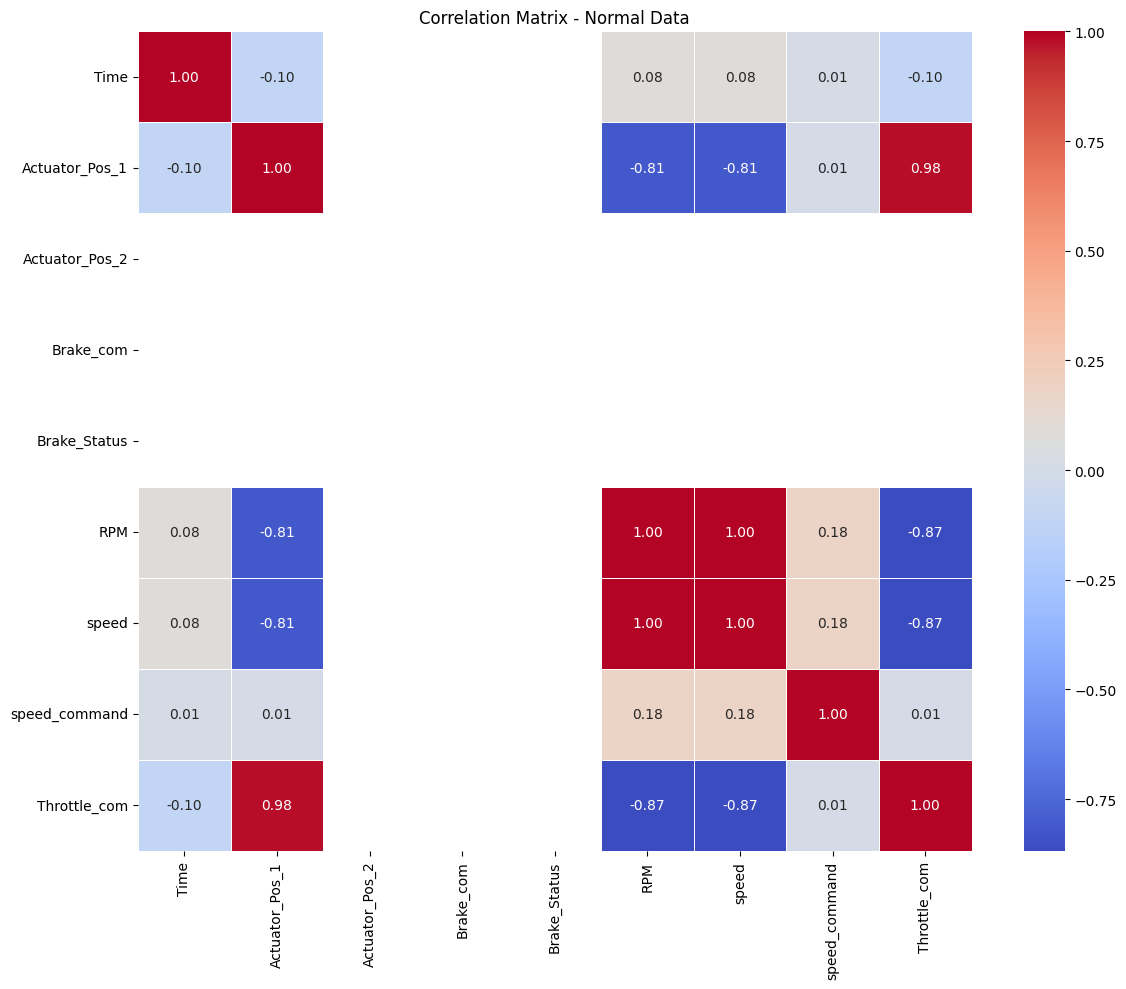

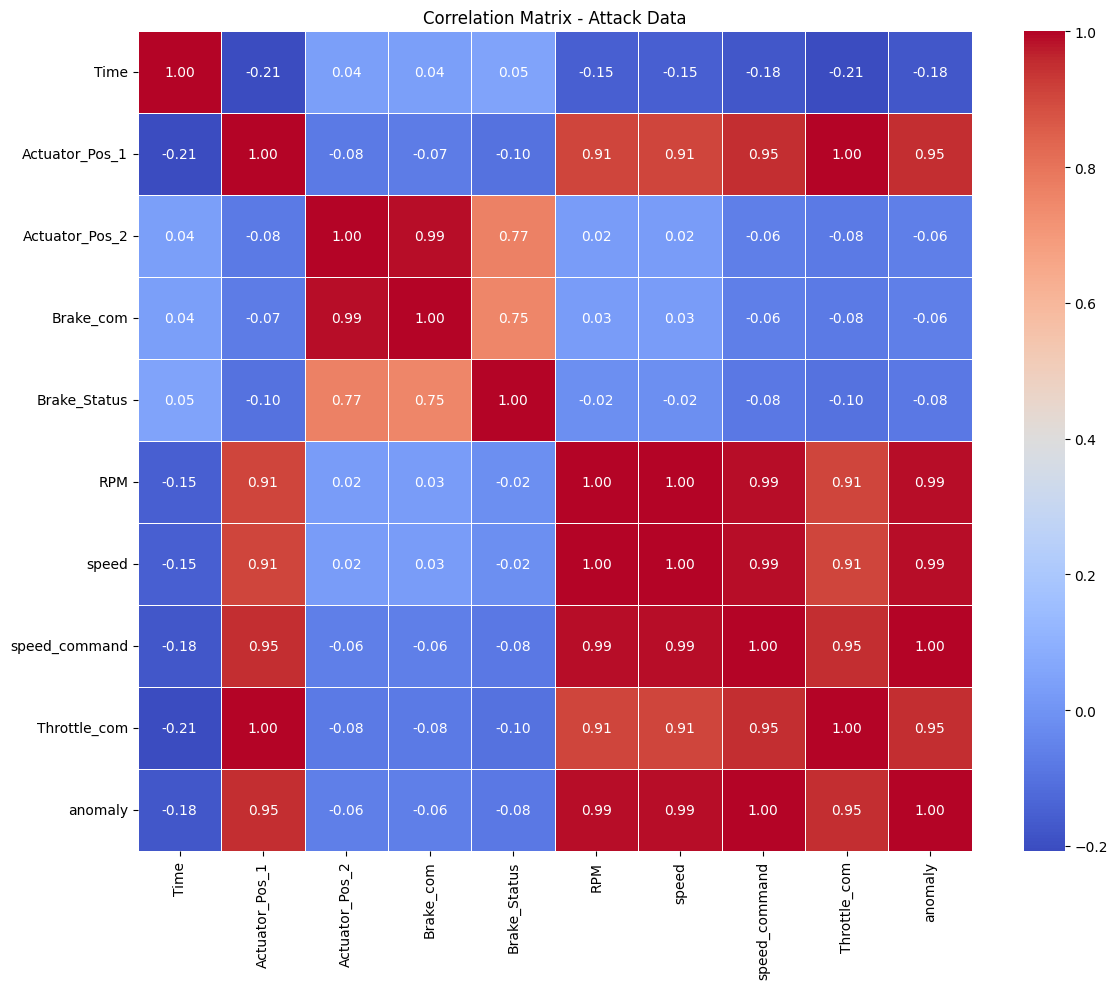


----- FEATURE DISTRIBUTIONS -----


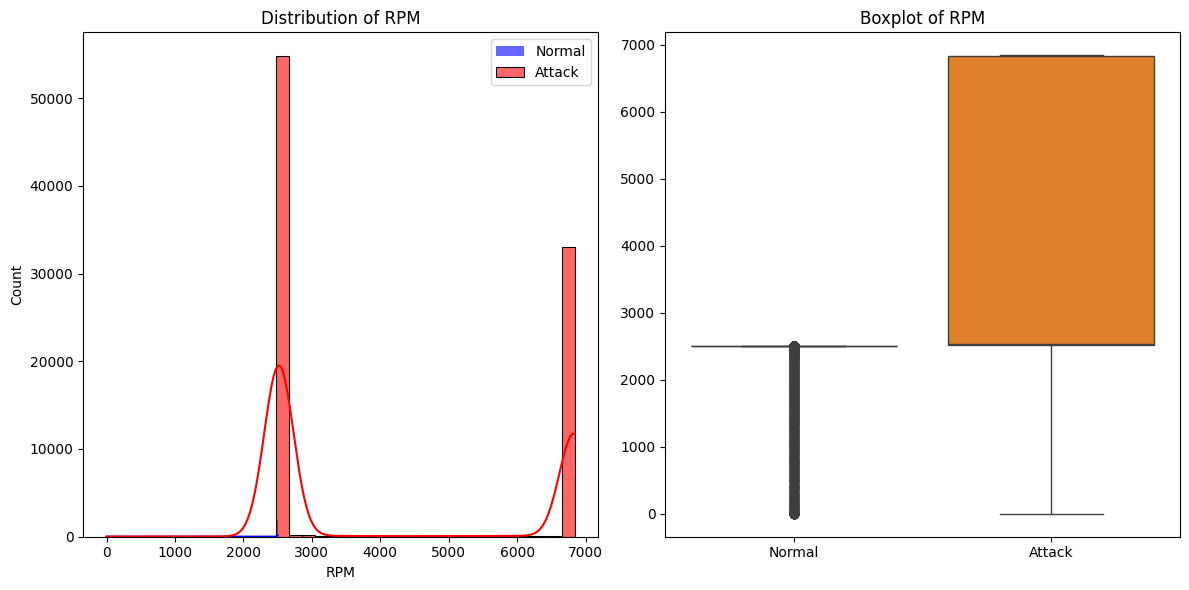

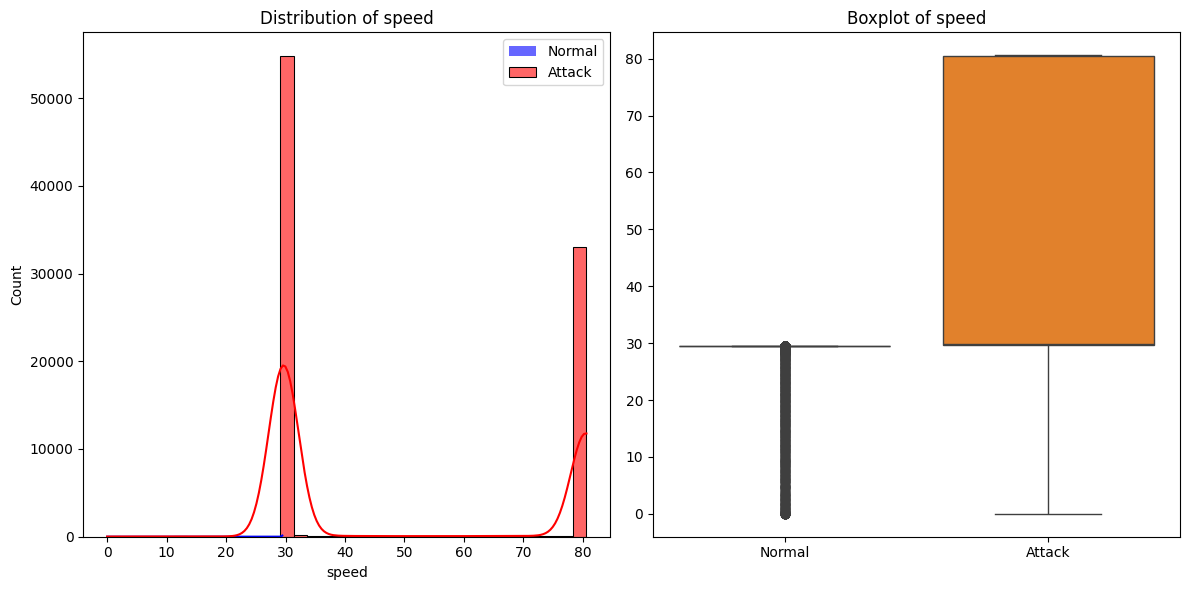

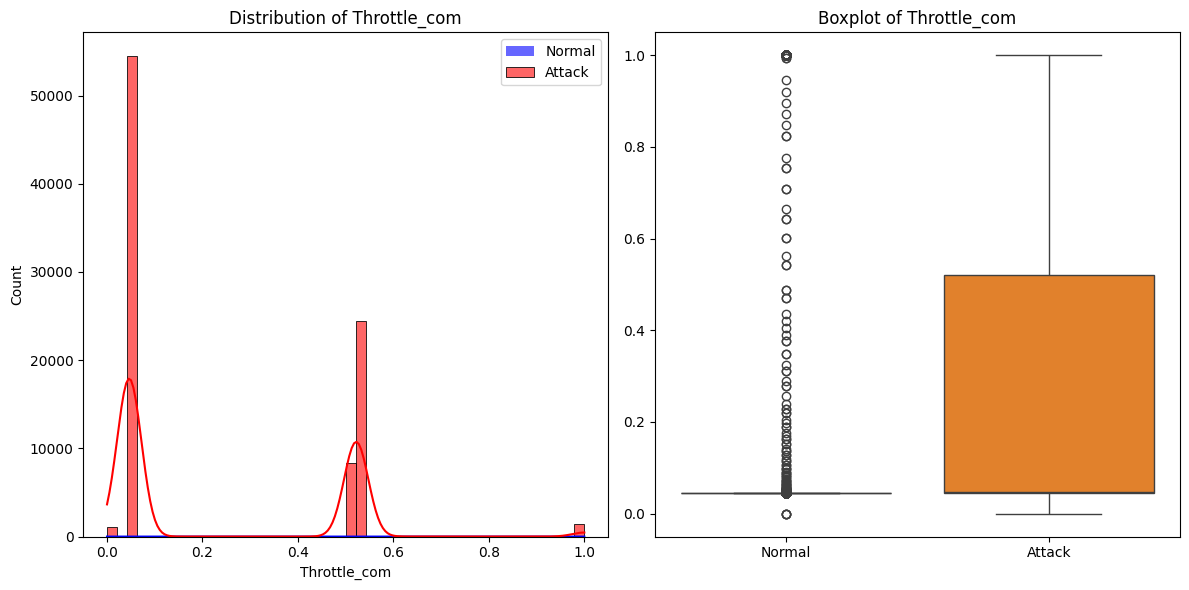

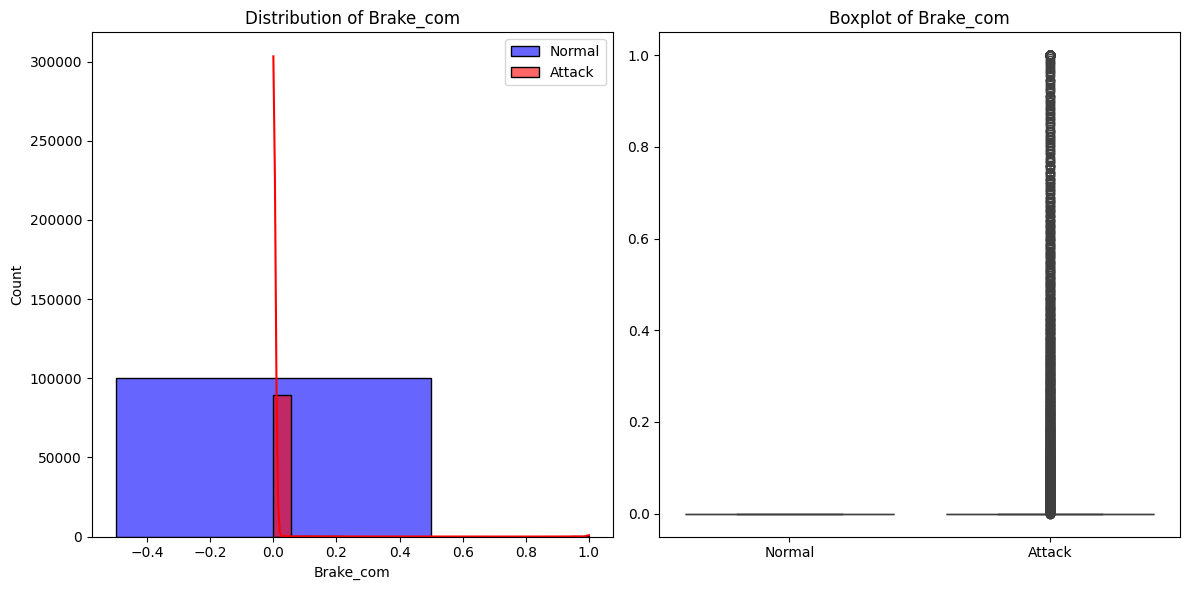

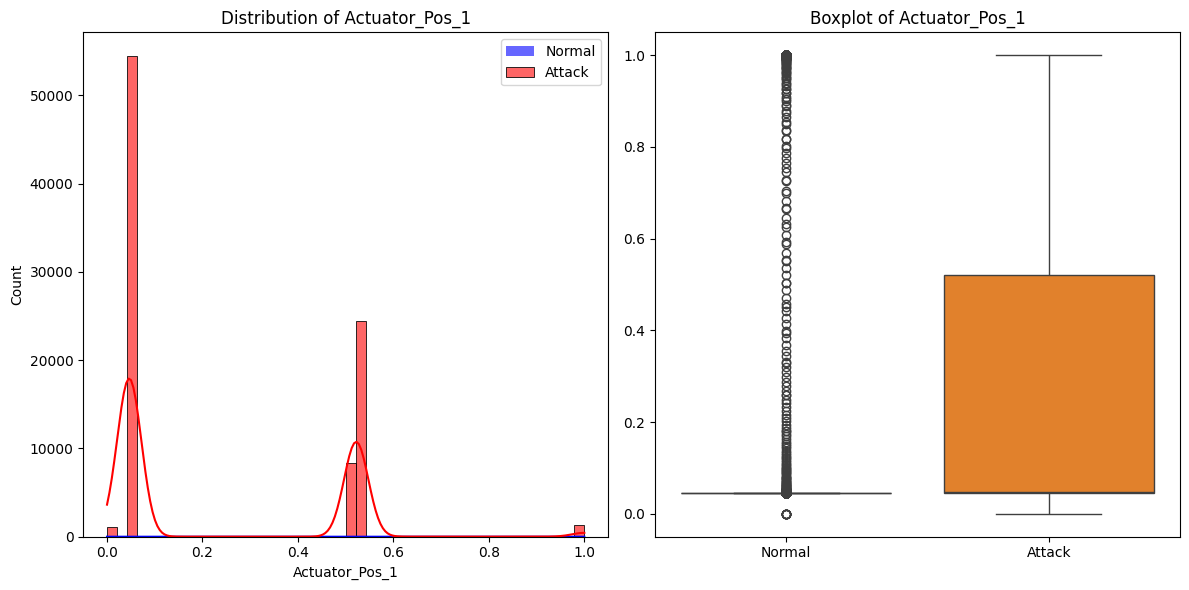

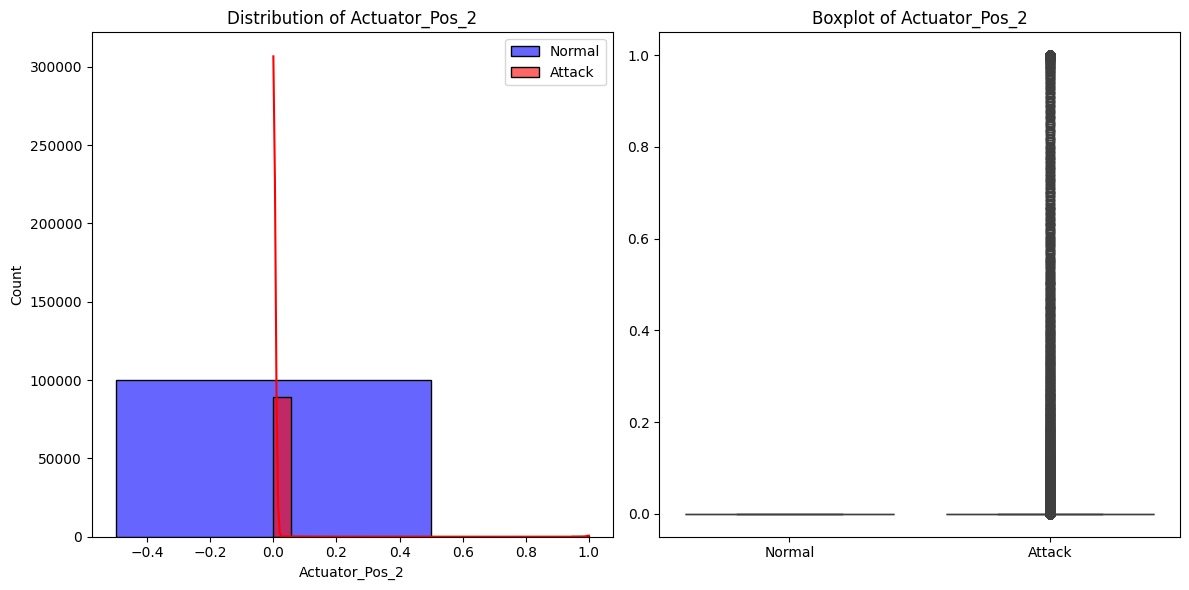


----- TIME SERIES VISUALIZATION -----


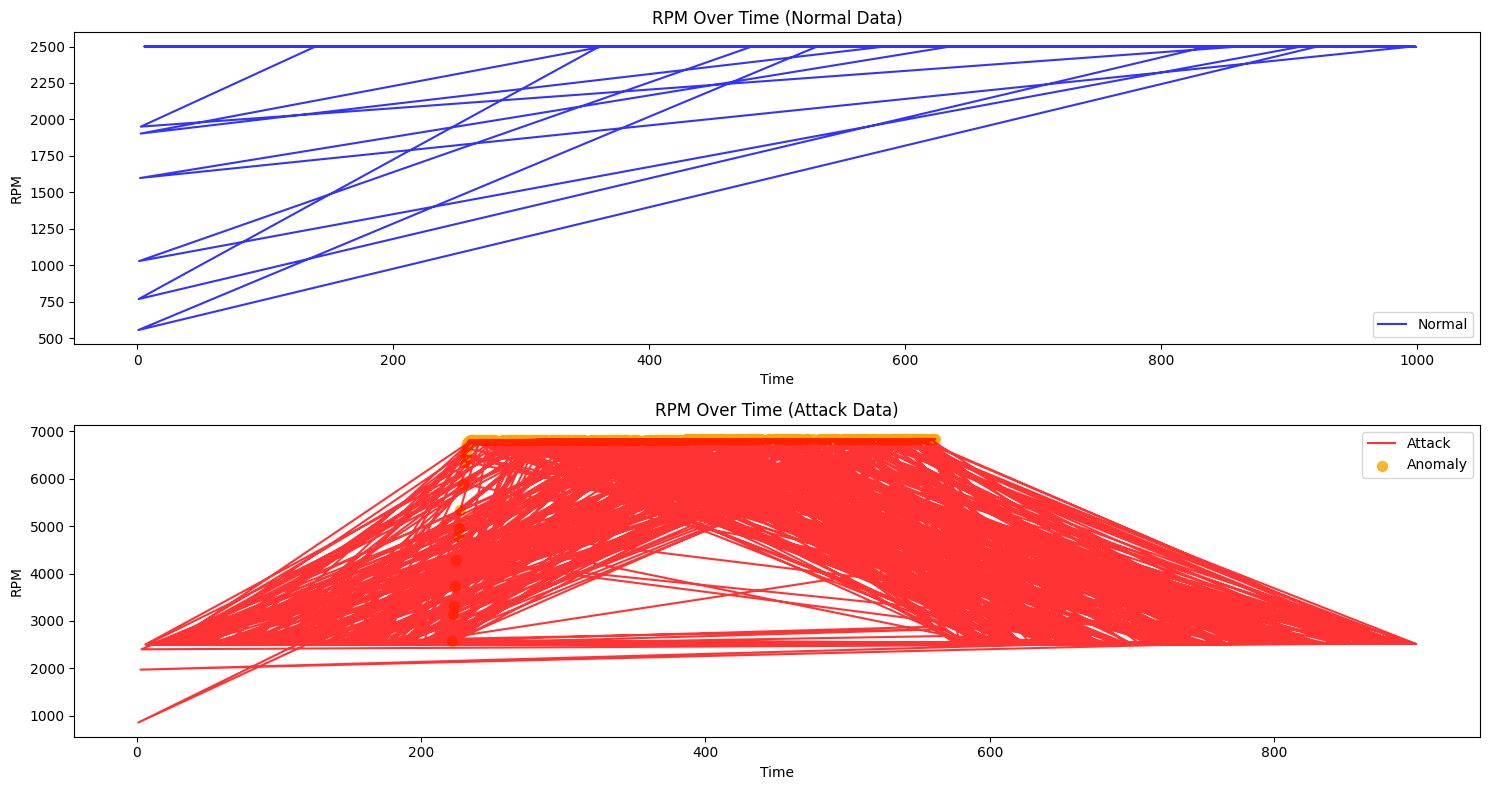

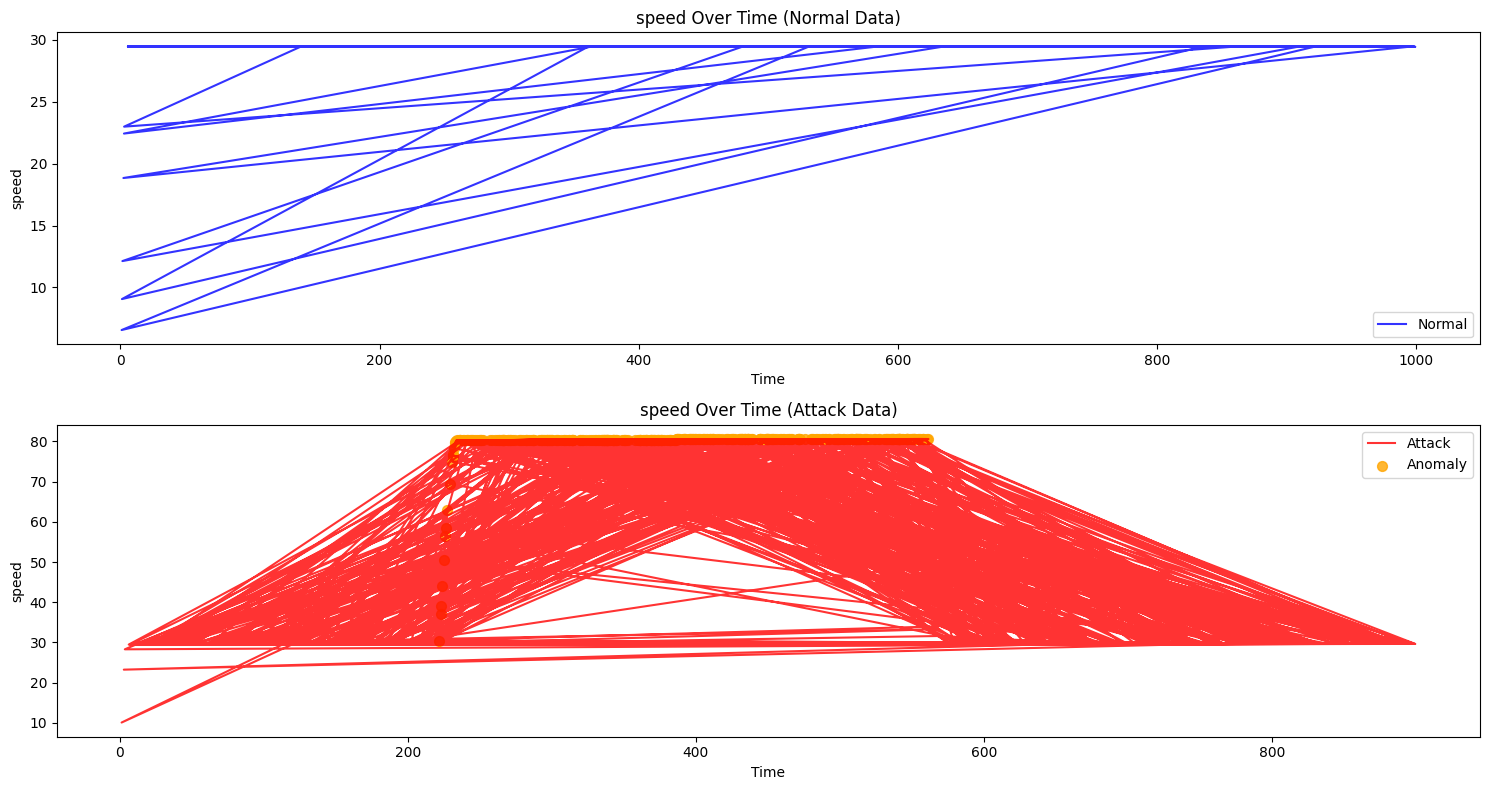

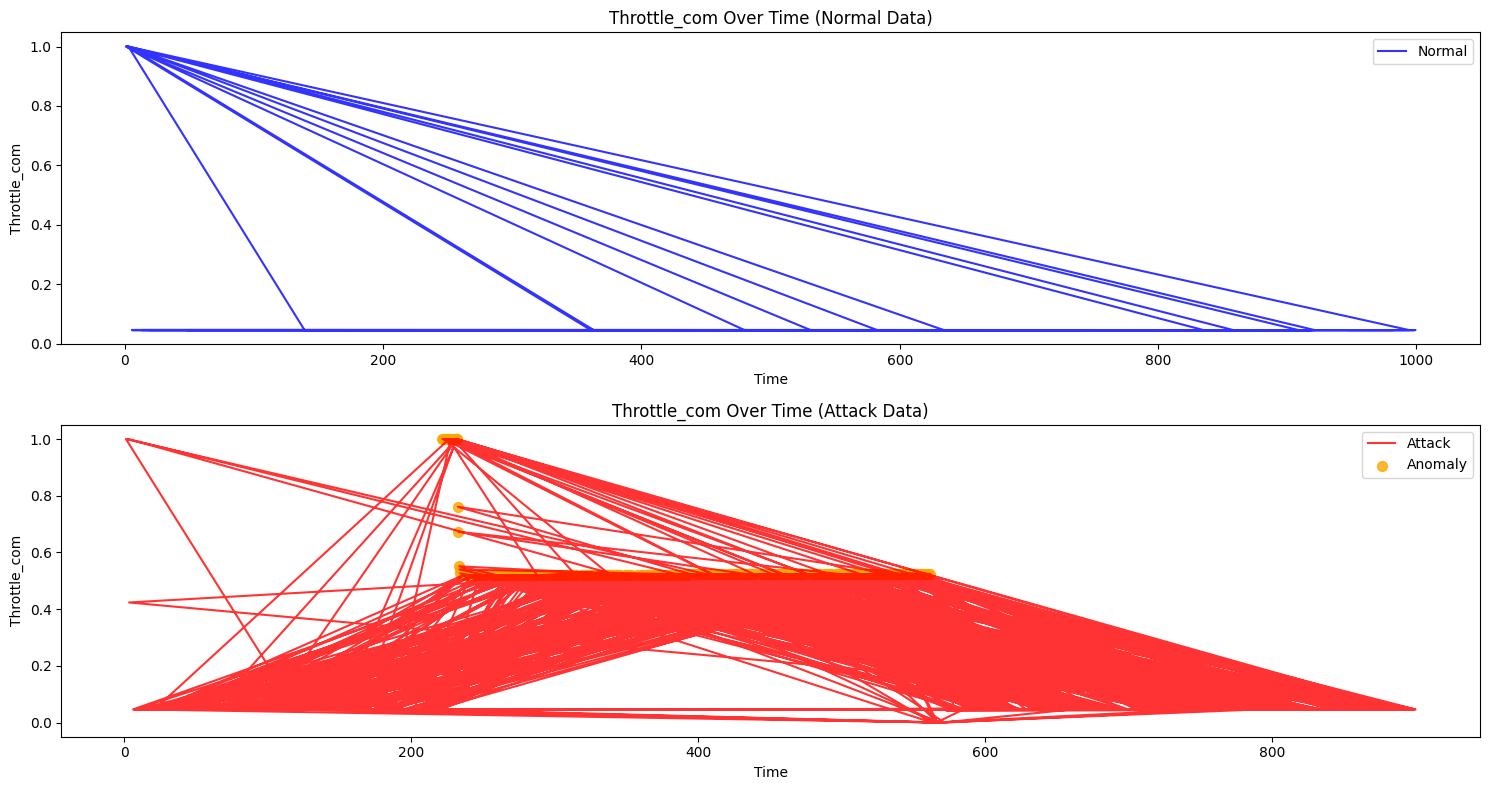

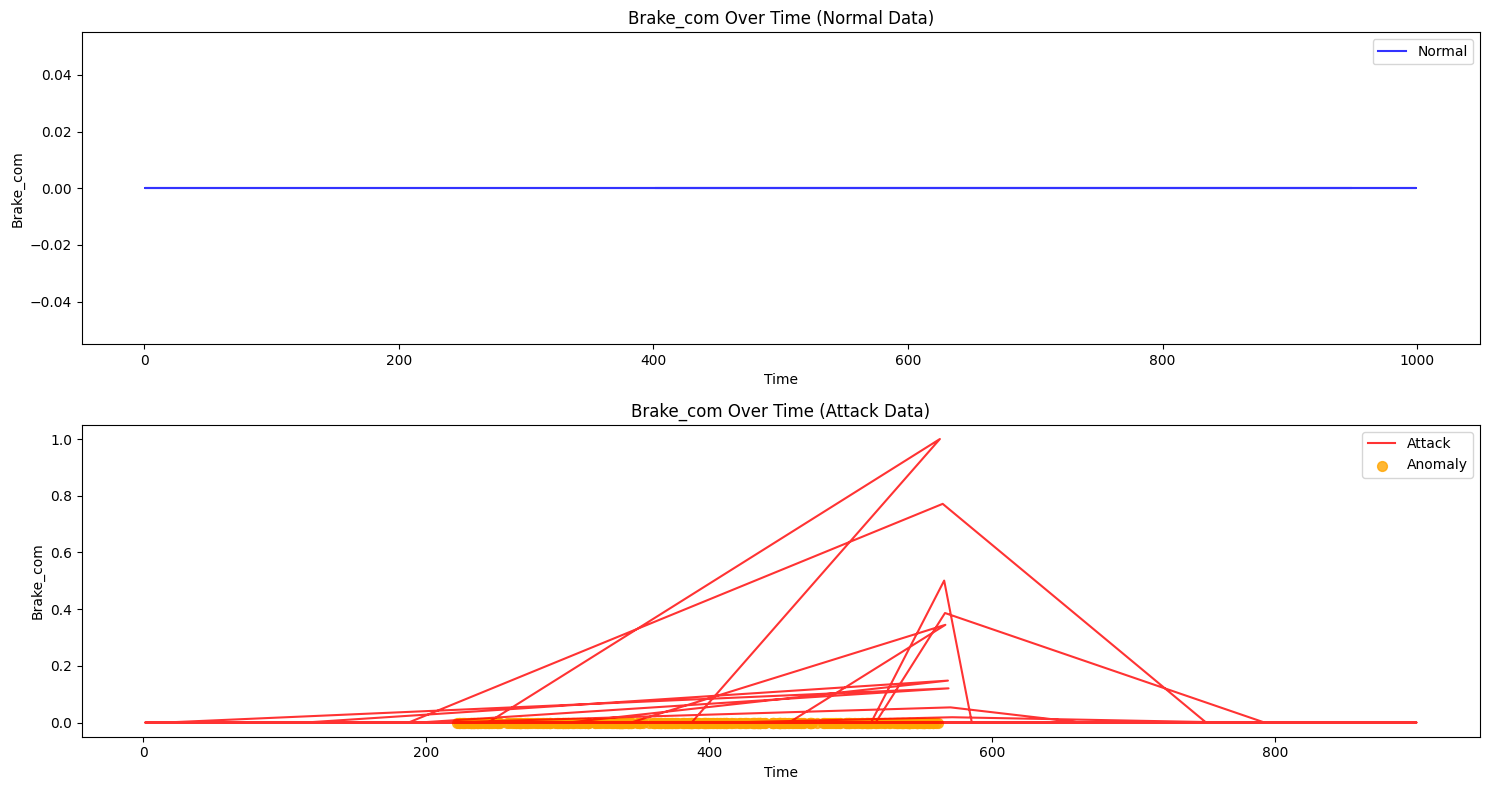


----- FEATURE RELATIONSHIPS -----


<Figure size 1200x1000 with 0 Axes>

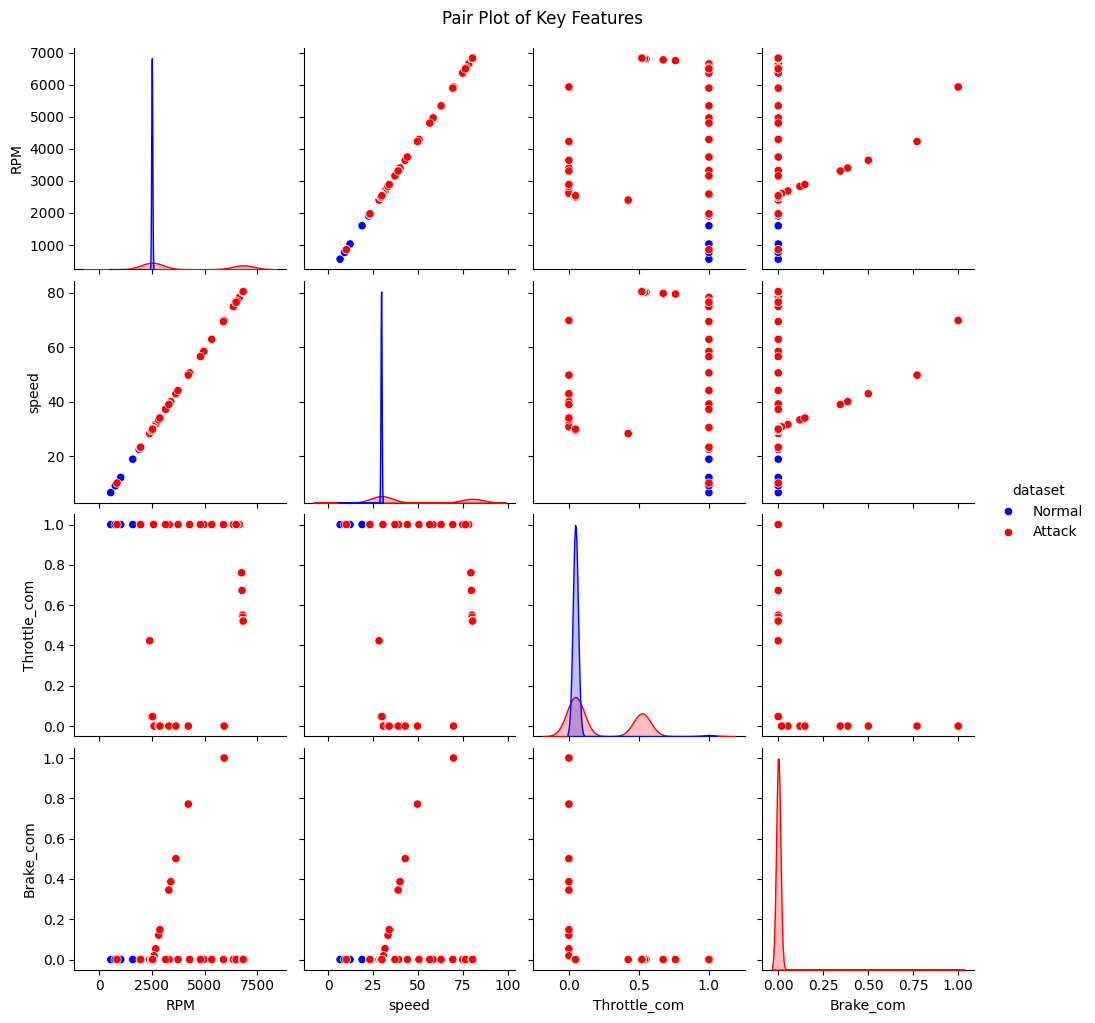


----- ANOMALY ANALYSIS -----
Number of anomalous points: 34027
Percentage of anomalous points: 37.81%

Statistical comparison between normal and anomalous points:

RPM:
  Normal mean: 2533.6800, std: 273.9034
  Anomaly mean: 6769.7709, std: 399.1889


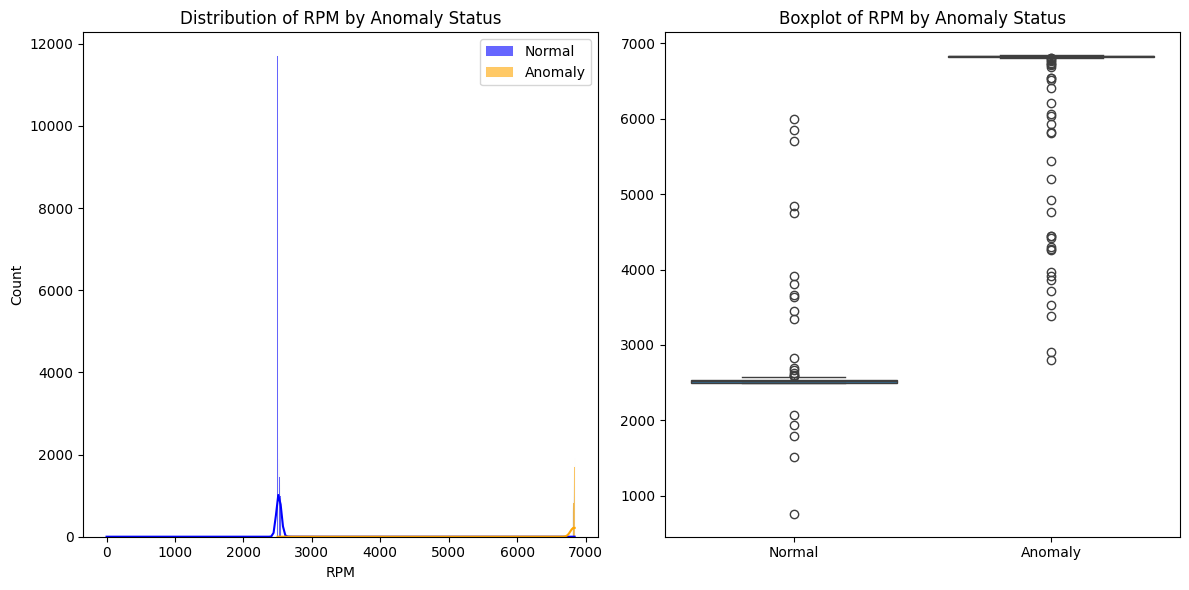


speed:
  Normal mean: 29.8492, std: 3.2264
  Anomaly mean: 79.7546, std: 4.7025


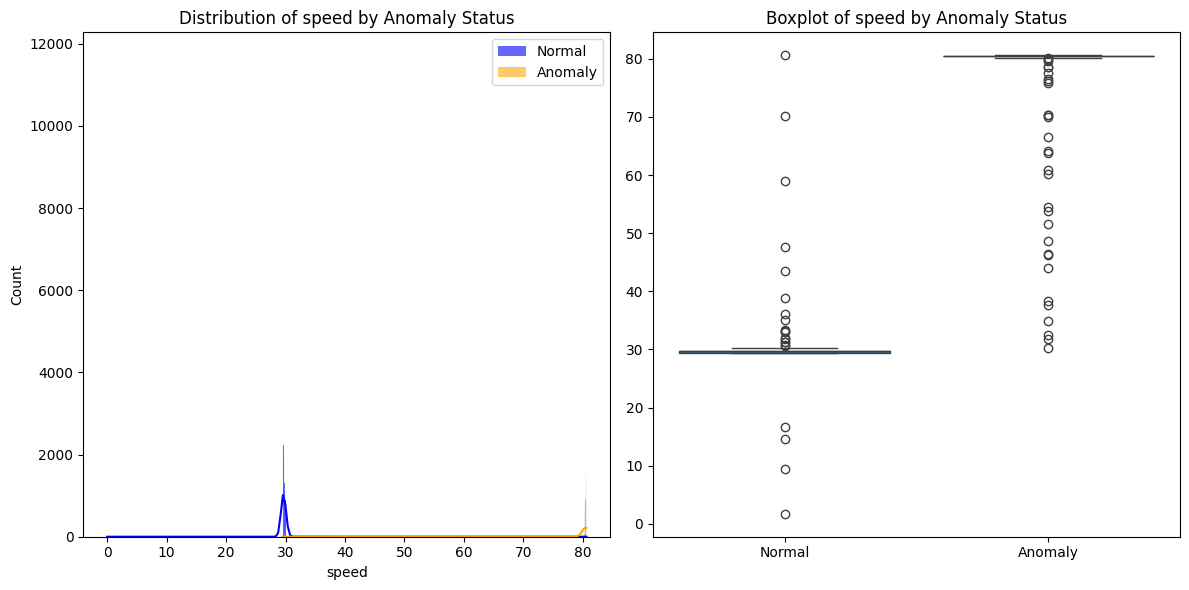


Throttle_com:
  Normal mean: 0.0516, std: 0.0735
  Anomaly mean: 0.5378, std: 0.0846


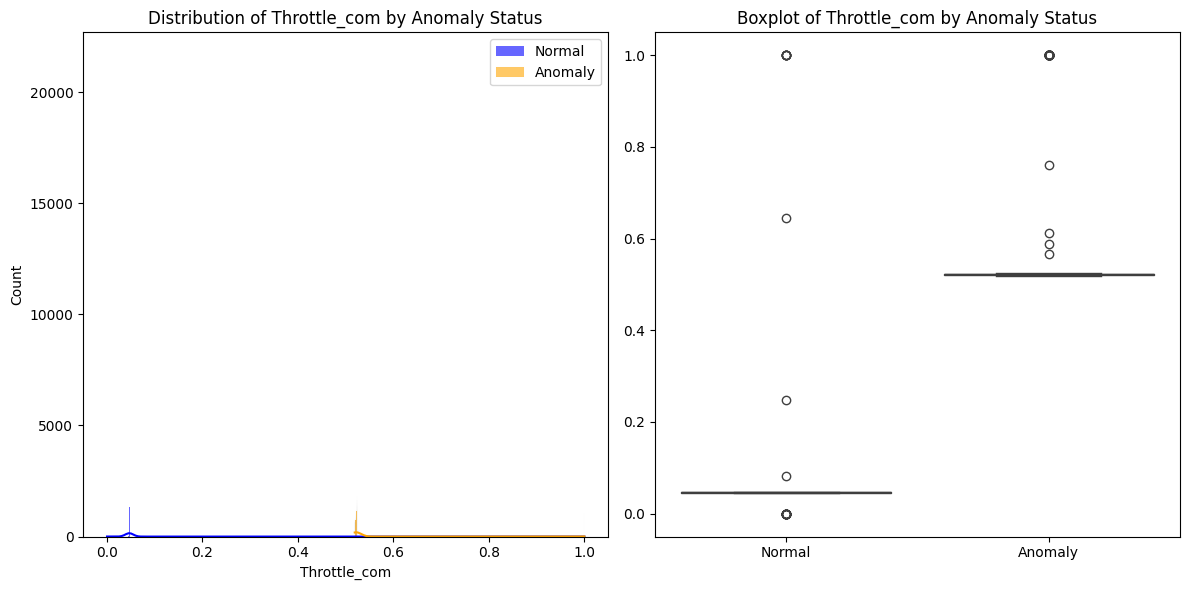


Brake_com:
  Normal mean: 0.0084, std: 0.0805
  Anomaly mean: 0.0000, std: 0.0000


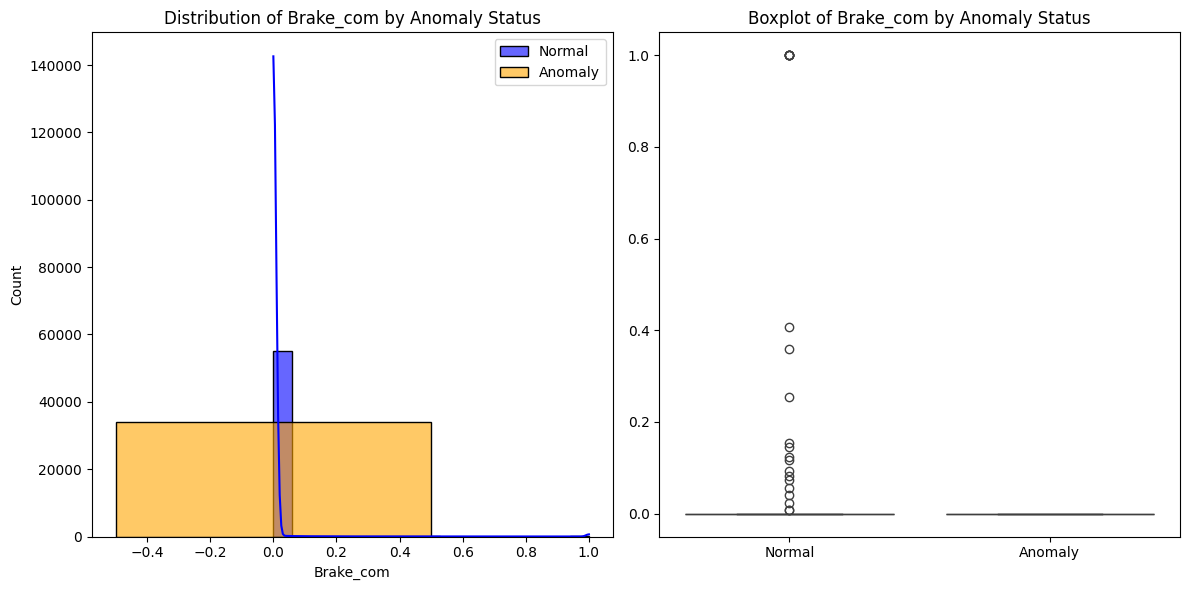


Actuator_Pos_1:
  Normal mean: 0.0517, std: 0.0729
  Anomaly mean: 0.5376, std: 0.0842


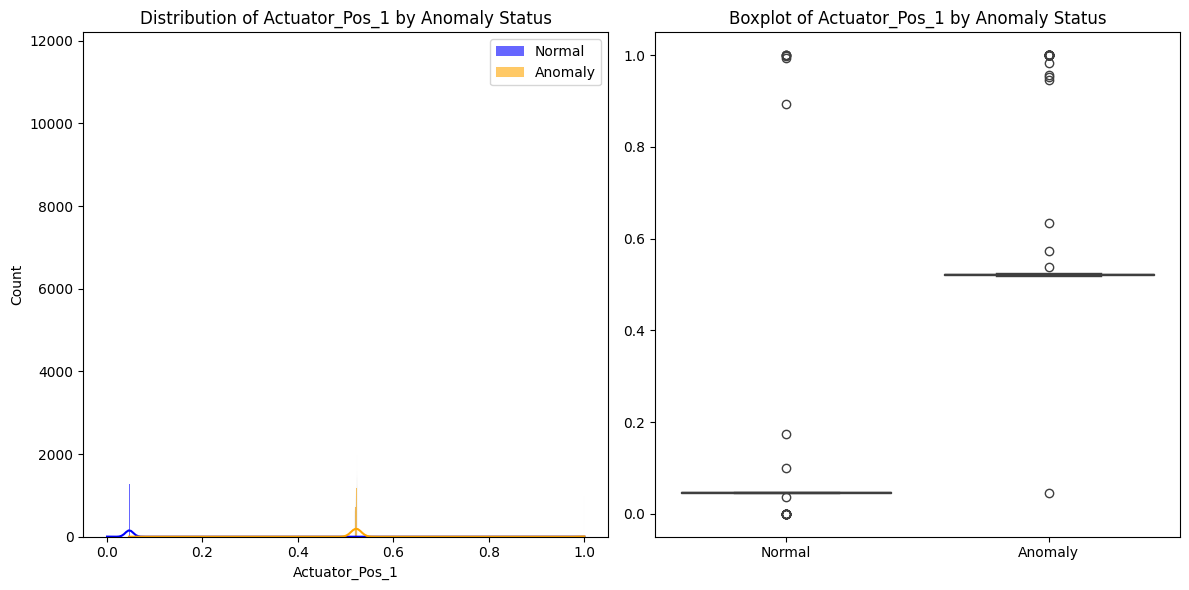


Actuator_Pos_2:
  Normal mean: 0.0083, std: 0.0797
  Anomaly mean: 0.0000, std: 0.0000


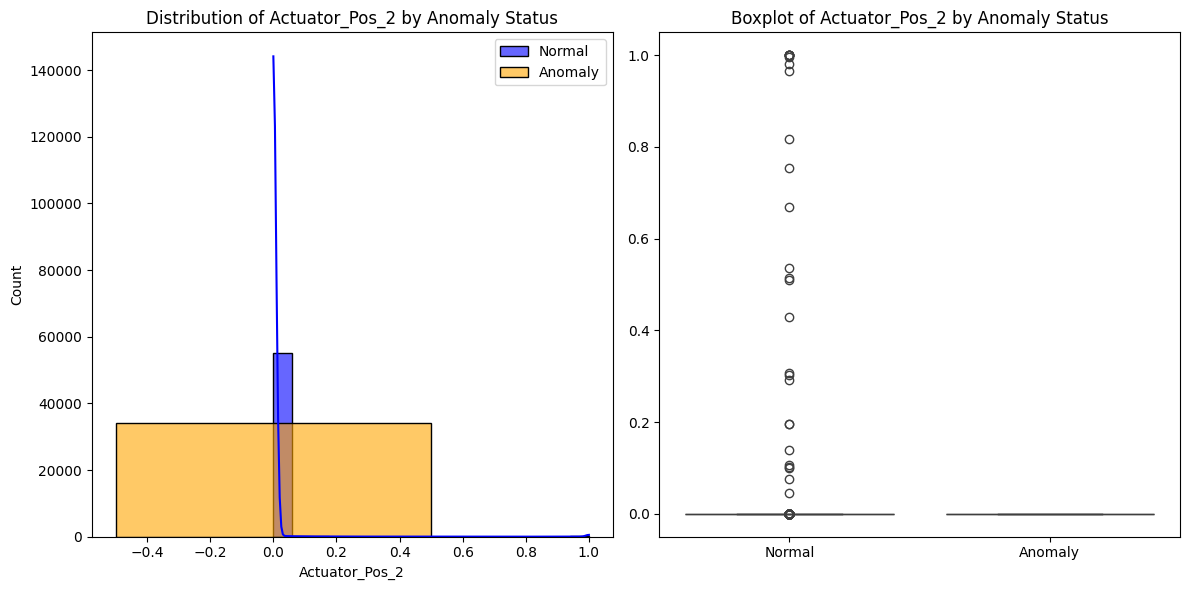


----- EDA SUMMARY -----
Key observations from exploratory data analysis:
- Missing values need to be handled in the preprocessing stage
- High correlations found in normal data, consider feature selection or dimensionality reduction
- Anomaly class distribution: 37.81% of attack data are anomalies

EDA completed successfully


In [5]:
# 1. Basic data information
print("\n----- BASIC DATA INFORMATION -----")
print("\nNormal Data Info:")
print(normal_df.info())
print("\nAttack Data Info:")
print(attack_df.info())

# 2. Statistical summary
print("\n----- STATISTICAL SUMMARY -----")
print("\nNormal Data Summary:")
print(normal_df.describe())
print("\nAttack Data Summary:")
print(attack_df.describe())

# 3. Checking for missing values
print("\n----- MISSING VALUES -----")
print("\nMissing values in normal data:")
print(normal_df.isnull().sum())
print("\nMissing values in attack data:")
print(attack_df.isnull().sum())

# 4. Checking for duplicates
print("\n----- DUPLICATE ROWS -----")
print(f"Normal data duplicates: {normal_df.duplicated().sum()}")
print(f"Attack data duplicates: {attack_df.duplicated().sum()}")

# 5. Class distribution (anomaly vs normal)
print("\n----- CLASS DISTRIBUTION -----")
if 'anomaly' in attack_df.columns:
    anomaly_counts = attack_df['anomaly'].value_counts()
    print("\nAnomaly distribution in attack data:")
    print(anomaly_counts)
    print(f"Percentage of anomalies: {anomaly_counts.get(1, 0)/len(attack_df)*100:.2f}%")
else:
    print("No 'anomaly' column found in attack data")

# 6. Time series analysis
print("\n----- TIME SERIES ANALYSIS -----")
# Check time steps
if 'Time' in normal_df.columns:
    time_diffs_normal = normal_df['Time'].diff().dropna()
    print(f"Normal data time step statistics:")
    print(f"  Mean: {time_diffs_normal.mean():.6f}")
    print(f"  Min: {time_diffs_normal.min():.6f}")
    print(f"  Max: {time_diffs_normal.max():.6f}")

if 'Time' in attack_df.columns:
    time_diffs_attack = attack_df['Time'].diff().dropna()
    print(f"Attack data time step statistics:")
    print(f"  Mean: {time_diffs_attack.mean():.6f}")
    print(f"  Min: {time_diffs_attack.min():.6f}")
    print(f"  Max: {time_diffs_attack.max():.6f}")

# 7. Correlation analysis
print("\n----- CORRELATION ANALYSIS -----")
# Normal data correlation
plt.figure(figsize=(12, 10))
corr_normal = normal_df.select_dtypes(include=['number']).corr()
sns.heatmap(corr_normal, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - Normal Data')
plt.tight_layout()
plt.show()

# Attack data correlation
plt.figure(figsize=(12, 10))
corr_attack = attack_df.select_dtypes(include=['number']).corr()
sns.heatmap(corr_attack, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - Attack Data')
plt.tight_layout()
plt.show()

# 8. Feature distributions
print("\n----- FEATURE DISTRIBUTIONS -----")
# Compare distributions of key features
features_to_plot = ['RPM', 'speed', 'Throttle_com', 'Brake_com', 'Actuator_Pos_1', 'Actuator_Pos_2']

for feature in features_to_plot:
    if feature in normal_df.columns and feature in attack_df.columns:
        plt.figure(figsize=(12, 6))

        # Plot histograms
        plt.subplot(1, 2, 1)
        sns.histplot(normal_df[feature], kde=True, label='Normal', color='blue', alpha=0.6)
        sns.histplot(attack_df[feature], kde=True, label='Attack', color='red', alpha=0.6)
        plt.title(f'Distribution of {feature}')
        plt.legend()

        # Plot boxplots
        plt.subplot(1, 2, 2)
        data_to_plot = pd.DataFrame({
            'Normal': normal_df[feature],
            'Attack': attack_df[feature]
        })
        sns.boxplot(data=data_to_plot)
        plt.title(f'Boxplot of {feature}')

        plt.tight_layout()
        plt.show()

# 9. Time series visualization
print("\n----- TIME SERIES VISUALIZATION -----")
# Sample a subset of data for visualization (to avoid overcrowding plots)
sample_size = min(1000, len(normal_df), len(attack_df))
normal_sample = normal_df.sample(sample_size, random_state=42) if len(normal_df) > sample_size else normal_df
attack_sample = attack_df.sample(sample_size, random_state=42) if len(attack_df) > sample_size else attack_df

# Plot time series for important features
time_series_features = ['RPM', 'speed', 'Throttle_com', 'Brake_com']

for feature in time_series_features:
    if feature in normal_df.columns and feature in attack_df.columns:
        plt.figure(figsize=(15, 8))

        # Plot normal data
        plt.subplot(2, 1, 1)
        plt.plot(normal_sample['Time'], normal_sample[feature], label='Normal', color='blue', alpha=0.8)
        plt.title(f'{feature} Over Time (Normal Data)')
        plt.xlabel('Time')
        plt.ylabel(feature)
        plt.legend()

        # Plot attack data
        plt.subplot(2, 1, 2)
        plt.plot(attack_sample['Time'], attack_sample[feature], label='Attack', color='red', alpha=0.8)

        # If anomaly column exists, highlight anomalies
        if 'anomaly' in attack_sample.columns:
            anomaly_points = attack_sample[attack_sample['anomaly'] == 1]
            if not anomaly_points.empty:
                plt.scatter(anomaly_points['Time'], anomaly_points[feature],
                           color='orange', alpha=0.8, s=50, label='Anomaly')

        plt.title(f'{feature} Over Time (Attack Data)')
        plt.xlabel('Time')
        plt.ylabel(feature)
        plt.legend()

        plt.tight_layout()
        plt.show()

# 10. Pair plots for feature relationships
print("\n----- FEATURE RELATIONSHIPS -----")
# Select a subset of features for pair plot (to avoid overcrowding)
pair_features = ['RPM', 'speed', 'Throttle_com', 'Brake_com']
pair_features = [f for f in pair_features if f in normal_df.columns and f in attack_df.columns]

if len(pair_features) >= 2:
    # Sample data for pair plot (to avoid slow rendering)
    sample_size_pair = min(1000, len(normal_df), len(attack_df))
    normal_sample_pair = normal_df.sample(sample_size_pair, random_state=42)[pair_features] if len(normal_df) > sample_size_pair else normal_df[pair_features]
    attack_sample_pair = attack_df.sample(sample_size_pair, random_state=42)[pair_features] if len(attack_df) > sample_size_pair else attack_df[pair_features]

    # Add dataset label for combined plot
    normal_sample_pair['dataset'] = 'Normal'
    attack_sample_pair['dataset'] = 'Attack'
    combined_sample = pd.concat([normal_sample_pair, attack_sample_pair])

    # Create pair plot
    plt.figure(figsize=(12, 10))
    sns.pairplot(combined_sample, hue='dataset', palette={'Normal': 'blue', 'Attack': 'red'}, diag_kind='kde')
    plt.suptitle('Pair Plot of Key Features', y=1.02)
    plt.show()

# 11. Featuring behavior during anomalies
print("\n----- ANOMALY ANALYSIS -----")
if 'anomaly' in attack_df.columns:
    # Separate anomalous and normal points in attack data
    attack_anomaly = attack_df[attack_df['anomaly'] == 1]
    attack_normal = attack_df[attack_df['anomaly'] == 0]

    if not attack_anomaly.empty:
        print(f"Number of anomalous points: {len(attack_anomaly)}")
        print(f"Percentage of anomalous points: {len(attack_anomaly)/len(attack_df)*100:.2f}%")

        print("\nStatistical comparison between normal and anomalous points:")
        for feature in ['RPM', 'speed', 'Throttle_com', 'Brake_com', 'Actuator_Pos_1', 'Actuator_Pos_2']:
            if feature in attack_df.columns:
                print(f"\n{feature}:")
                print(f"  Normal mean: {attack_normal[feature].mean():.4f}, std: {attack_normal[feature].std():.4f}")
                print(f"  Anomaly mean: {attack_anomaly[feature].mean():.4f}, std: {attack_anomaly[feature].std():.4f}")

                # Plot comparison
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                sns.histplot(attack_normal[feature], kde=True, label='Normal', color='blue', alpha=0.6)
                sns.histplot(attack_anomaly[feature], kde=True, label='Anomaly', color='orange', alpha=0.6)
                plt.title(f'Distribution of {feature} by Anomaly Status')
                plt.legend()

                plt.subplot(1, 2, 2)
                boxplot_data = pd.DataFrame({
                    'Normal': attack_normal[feature].sample(min(1000, len(attack_normal))),
                    'Anomaly': attack_anomaly[feature].sample(min(1000, len(attack_anomaly)))
                })
                sns.boxplot(data=boxplot_data)
                plt.title(f'Boxplot of {feature} by Anomaly Status')

                plt.tight_layout()
                plt.show()

# 12. Summary of findings
print("\n----- EDA SUMMARY -----")
print("Key observations from exploratory data analysis:")

# Print any missing values
if normal_df.isnull().sum().sum() > 0 or attack_df.isnull().sum().sum() > 0:
    print("- Missing values need to be handled in the preprocessing stage")

# Print any duplicates
if normal_df.duplicated().sum() > 0 or attack_df.duplicated().sum() > 0:
    print("- Duplicate rows should be removed during preprocessing")

# Note any significant correlations
high_corr_normal = corr_normal.unstack().sort_values(ascending=False).drop_duplicates()
high_corr_normal = high_corr_normal[(high_corr_normal < 1.0) & (high_corr_normal > 0.8)]
if not high_corr_normal.empty:
    print("- High correlations found in normal data, consider feature selection or dimensionality reduction")

# Note anomaly distribution if available
if 'anomaly' in attack_df.columns:
    anomaly_percent = attack_df['anomaly'].mean() * 100
    print(f"- Anomaly class distribution: {anomaly_percent:.2f}% of attack data are anomalies")
    if anomaly_percent < 10:
        print("- The dataset is imbalanced, consider using appropriate techniques for handling imbalanced data")

print("\nEDA completed successfully")

## **Preprocessing Data**

In [8]:
def clean_data(df):
    # Making a copy to avoid warnings
    df = df.copy()

    # Check and report missing values
    missing_before = df.isna().sum().sum()
    print(f"Missing values: {missing_before}")

    # Filling missing values (forward and backward fill)
    df = df.fillna(method='ffill').fillna(method='bfill')

    # To Remove duplicates
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"Removing {duplicates} duplicate rows")
        df = df.drop_duplicates()

    # Extra checks I added to prevent some issue i was facing
    missing_after = df.isna().sum().sum()
    if missing_after > 0:
        print(f"Still have {missing_after} missing values after ffill/bfill, filling with zeros")
        df = df.fillna(0)
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col])
                print(f"Converted {col} to numeric")
            except:
                pass

    return df
# Cleaning
print("\nCleaning normal data...")
normal_df = clean_data(normal_df)
print("\nCleaning attack data...")
attack_df = clean_data(attack_df)
#Ensuring consistent columns between datasets
print("\nEnsuring consistent columns...")
all_columns = set(normal_df.columns) | set(attack_df.columns)

# Add missing columns with zeros
for col in all_columns:
    if col not in normal_df.columns:
        print(f"Adding missing column {col} to normal_df")
        normal_df[col] = 0
    if col not in attack_df.columns:
        print(f"Adding missing column {col} to attack_df")
        attack_df[col] = 0

# Ensure 'anomaly' column exists in both datasets
if 'anomaly' not in normal_df.columns:
    normal_df['anomaly'] = 0

# Feature engineering - now with clean data
def create_features(df):
    # Make a copy to avoid warnings
    df = df.copy()

    # Skip time-based features if 'Time' is just a numerical sequence
    if 'Time' in df.columns and isinstance(df['Time'].iloc[0], (datetime, np.datetime64)):
        df['hour'] = pd.to_datetime(df['Time']).dt.hour

    # Creating rolling statistics with proper handling
    for col in ['RPM', 'speed']:
        if col in df.columns:

            df[f'{col}_rolling_mean'] = df[col].rolling(window=5, min_periods=1).mean()
            df[f'{col}_rolling_std'] = df[col].rolling(window=5, min_periods=1).std()

            # Fill any NaNs that might be created
            df[f'{col}_rolling_mean'] = df[f'{col}_rolling_mean'].fillna(df[col])
            df[f'{col}_rolling_std'] = df[f'{col}_rolling_std'].fillna(0)

    # Check for successful feature creation
    new_features = [col for col in df.columns if ('rolling' in col or 'hour' in col)]
    print(f"Created {len(new_features)} new features: {new_features}")

    return df
    print("\nCreating features for normal data...")
    normal_df = create_features(normal_df)
    print("\nCreating features for attack data...")
    attack_df = create_features(attack_df)
    # Verify no NaNs in data
    print("\nChecking for NaNs after feature creation:")
    print(f"NaNs in normal_df: {normal_df.isna().sum().sum()}")
    print(f"NaNs in attack_df: {attack_df.isna().sum().sum()}")


Cleaning normal data...
Missing values: 5

Cleaning attack data...
Missing values: 6

Ensuring consistent columns...
Adding missing column anomaly to normal_df


## **Visualising**

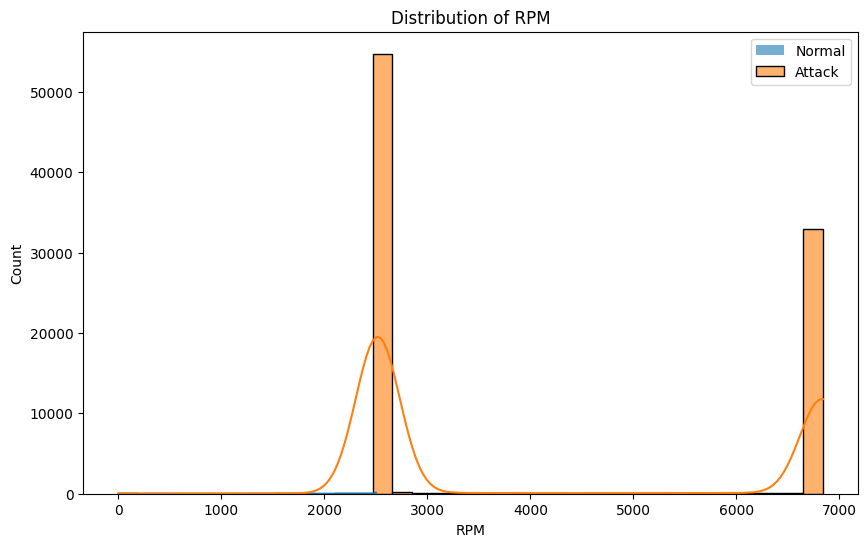

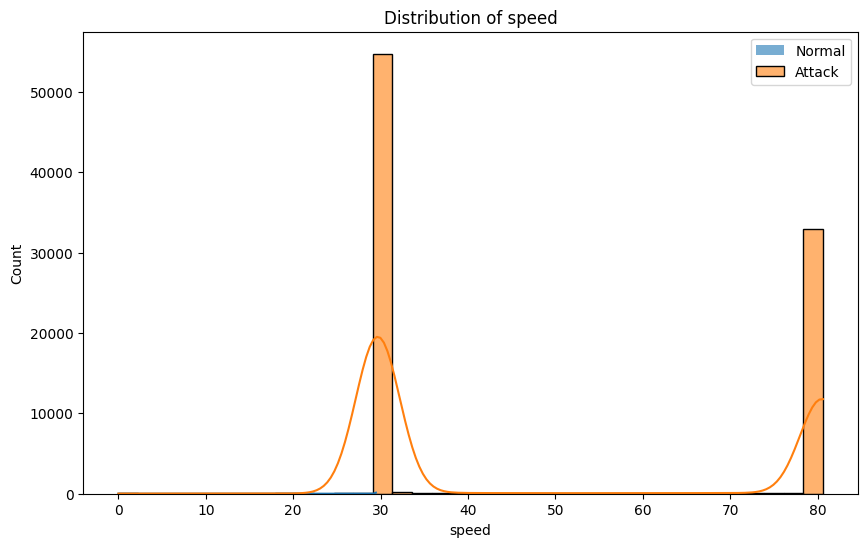

In [9]:

# Visualizing distributions
def plot_distributions(normal_df, attack_df, cols):
    for col in cols:
        if col in normal_df.columns and col in attack_df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(normal_df[col], label='Normal', alpha=0.6, kde=True)
            sns.histplot(attack_df[col], label='Attack', alpha=0.6, kde=True)
            plt.legend()
            plt.title(f'Distribution of {col}')
            plt.show()

# Visualize key features
plot_distributions(normal_df, attack_df, ['RPM', 'speed', 'RPM_rolling_std'])

## **Preparing Data**

In [10]:
# Prepare data for modeling - improved with balance checking
def prepare_data(normal_df, attack_df):
    # Label data
    normal_df = normal_df.copy()
    attack_df = attack_df.copy()

    normal_df['label'] = 0  # 0 for normal
    attack_df['label'] = 1  # 1 for attack

    # Combine datasets
    combined_df = pd.concat([normal_df, attack_df], ignore_index=True)

    # Check class balance
    class_counts = combined_df['label'].value_counts()
    print("\nClass distribution:")
    for label, count in class_counts.items():
        print(f"Class {label}: {count} samples ({count/len(combined_df)*100:.2f}%)")

    # Select features - excluding time and labels
    exclude_cols = ['Time', 'label', 'anomaly']
    features = [col for col in combined_df.columns if col not in exclude_cols]
    print(f"\nUsing {len(features)} features: {features}")

    # Split data
    X = combined_df[features]
    y = combined_df['label']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"Scaled data shape: {X_scaled.shape}")

    # Check for any remaining NaN or inf values
    invalid_values = np.isnan(X_scaled).sum() + np.isinf(X_scaled).sum()
    if invalid_values > 0:
        print(f"WARNING: Found {invalid_values} invalid values in scaled data")
        # Replace any NaN or inf values
        X_scaled = np.nan_to_num(X_scaled)
          # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training data shape: {X_train.shape}, {y_train.shape}")
    print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

    return X_train, X_test, y_train, y_test, scaler, features

X_train, X_test, y_train, y_test, scaler, features = prepare_data(normal_df, attack_df)



Class distribution:
Class 0: 100001 samples (52.63%)
Class 1: 90005 samples (47.37%)

Using 8 features: ['Actuator_Pos_1', 'Actuator_Pos_2', 'Brake_com', 'Brake_Status', 'RPM', 'speed', 'speed_command', 'Throttle_com']
Scaled data shape: (190006, 8)
Training data shape: (152004, 8), (152004,)
Testing data shape: (38002, 8), (38002,)


## **Isolation Forest**

In [11]:
# Train Isolation Forest
print("\n--- Isolation Forest ---")
contamination = y_train.mean()
print(f"Using contamination value: {contamination:.4f}")

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_train)

# Predictions
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Convert to 0/1 labels

# Evaluate
print("\nIsolation Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_iso):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_iso):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_iso):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_iso):.4f}")
# Show confusion matrix
cm = confusion_matrix(y_test, y_pred_iso)
print("\nConfusion Matrix:")
print(cm)


--- Isolation Forest ---
Using contamination value: 0.4737

Isolation Forest Results:
Accuracy: 0.9031
Precision: 0.8957
Recall: 0.9003
F1 Score: 0.8980

Confusion Matrix:
[[18113  1888]
 [ 1795 16206]]


## **LSTM Autoencoder**


--- LSTM Autoencoder ---
Normal training data shape: (80000, 8)
Sequence training data shape: (79996, 5, 8)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 5, 64)          │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 40)             │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 5, 8)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,480 (130.78 KB)

 Trainable params: 33,480 (130.78 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0249 - mae: 0.0513 - val_loss: 0.0027 - val_mae: 0.0054
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0025 - mae: 0.0058 - val_loss: 0.0011 - val_mae: 0.0040
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0016 - mae: 0.0045 - val_loss: 0.0012 - val_mae: 0.0042
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0014 - mae: 0.0044 - val_loss: 0.0014 - val_mae: 0.0041
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0012 - mae: 0.0041 - val_loss: 0.0011 - val_mae: 0.0038
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 9.5995e-04 - mae: 0.0039 - val_loss: 0.0015 - val_mae: 0.0039
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 7.8564e-04 - mae: 0.0036 - val_loss: 0.0011 - val_mae: 0.0038
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 7.3260e-04 - mae: 0.0035 - val_loss: 9.3930e-04 - val_mae: 0.0033
Epoch 9/20


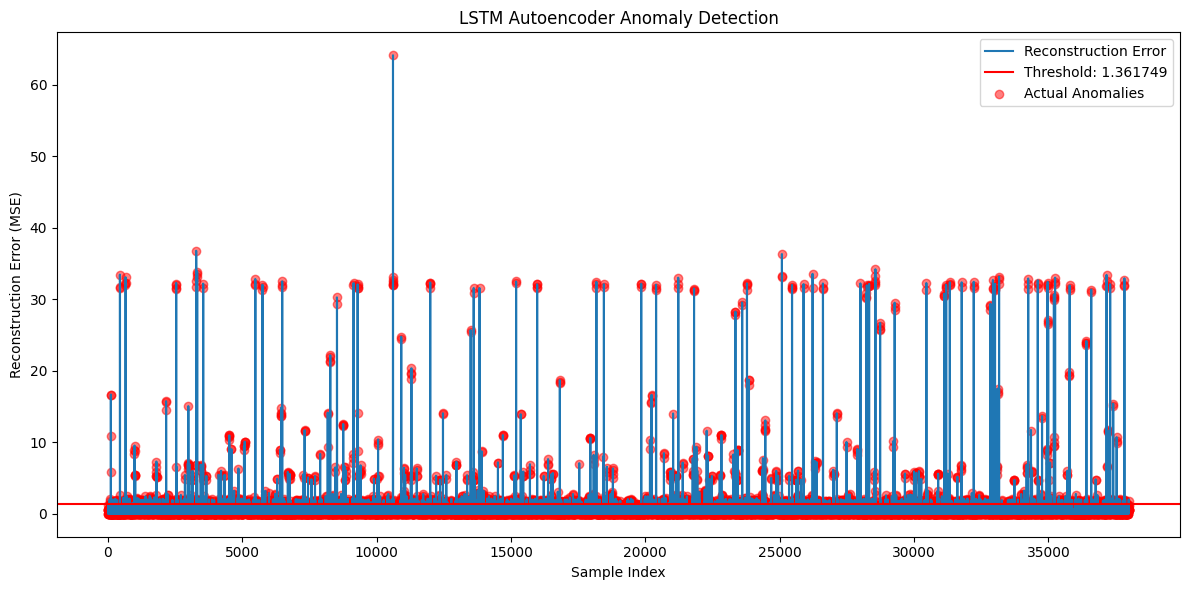

In [16]:
# LSTM Autoencoder
print("\n--- LSTM Autoencoder ---")

def create_sequences(data, seq_length=5):
    """Create sequences for LSTM model with proper reshaping"""
    X_seq = []
    for i in range(len(data) - seq_length + 1):
        X_seq.append(data[i:i+seq_length])
    return np.array(X_seq)

# Get normal data only for training the autoencoder
X_train_normal = X_train[y_train == 0]
print(f"Normal training data shape: {X_train_normal.shape}")

# Creatinig sequences for LSTM
seq_length = 5  # Adjust based on your time series characteristics
X_train_seq = create_sequences(X_train_normal, seq_length)
print(f"Sequence training data shape: {X_train_seq.shape}")

# LSTM Autoencoder
def create_lstm_autoencoder(seq_length, n_features):
    model = Sequential([
        # Encoder
        LSTM(64, activation='relu', input_shape=(seq_length, n_features),
             return_sequences=True),
        Dropout(0.2),  # Add dropout for regularization
        LSTM(32, activation='relu', return_sequences=False),
        Dropout(0.2),

        # Decoder (for reconstruction)
        Dense(32, activation='relu'),
        Dense(seq_length * n_features, activation='linear'),
        tf.keras.layers.Reshape((seq_length, n_features))
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

# Creating and training the model
n_features = X_train_normal.shape[1]
autoencoder = create_lstm_autoencoder(seq_length, n_features)
print(autoencoder.summary())

# Training with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_seq, X_train_seq,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Create sequences for test data (using the same approach as training data)
seq_length = 5  # Make sure this matches what you used for training
def create_sequences(data, seq_length=5):
    X_seq = []
    for i in range(len(data) - seq_length + 1):
        X_seq.append(data[i:i+seq_length])
    return np.array(X_seq)

# Create proper sequences for LSTM (this is the key fix)
X_test_seq = create_sequences(X_test, seq_length)
print(f"Test sequence shape: {X_test_seq.shape}")  # Should be (n_samples, seq_length, n_features)

# Get reconstructions from autoencoder
reconstructions = autoencoder.predict(X_test_seq)
print(f"Reconstruction shape: {reconstructions.shape}")

# Compute Mean Squared Error (MSE) between original sequences and reconstructions
mse = np.mean(np.power(X_test_seq - reconstructions, 2), axis=(1, 2))
print(f"MSE shape: {mse.shape}")

# Align labels with sequences
y_test_seq = y_test[seq_length-1:seq_length-1+len(X_test_seq)]
print(f"Aligned test labels shape: {y_test_seq.shape}")

# Set threshold as 95th percentile of MSE for normal (non-attack) data
threshold = np.percentile(mse[y_test_seq == 0], 95)
print(f"Threshold value: {threshold:.6f}")

# Predict anomalies: 1 = anomaly, 0 = normal
y_pred = (mse > threshold).astype(int)

# Evaluate performance with zero_division parameter for safety
print("\nLSTM Autoencoder Results:")
print(f"Accuracy:  {accuracy_score(y_test_seq, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_seq, y_pred, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_seq, y_pred, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test_seq, y_pred, zero_division=0):.4f}")

# Print confusion matrix for better understanding
cm = confusion_matrix(y_test_seq, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Calculate class-specific metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Add visualization of anomaly scores
def plot_anomaly_scores(mse, y_true, threshold, title="Anomaly Scores"):
    plt.figure(figsize=(12, 6))

    # Plot reconstruction error
    plt.plot(mse, label='Reconstruction Error')

    # Plot threshold
    plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold: {threshold:.6f}')

    # Highlight actual anomalies
    anomaly_indices = np.where(y_true == 1)[0]
    plt.scatter(anomaly_indices, mse[anomaly_indices], color='red', label='Actual Anomalies', alpha=0.5)

    plt.title(title)
    plt.ylabel('Reconstruction Error (MSE)')
    plt.xlabel('Sample Index')
    plt.legend()
    plt.tight_layout()
    plt.show()

# If we have valid results, plot the best threshold's performance
if len(X_test_seq) > 0:
    best_threshold_idx = 0  # Change this to the index of your best threshold
    plot_anomaly_scores(mse, y_test_seq, threshold, "LSTM Autoencoder Anomaly Detection")

## **Evaluation and Comparision Of Both The Models**


Running model evaluation...

Model                Accuracy   Precision  Recall     F1 Score  
-----------------------------------------------------------------
Isolation Forest     0.9031     0.8957     0.9003     0.8980    
LSTM Autoencoder     0.5533     0.6697     0.1127     0.1929    

----- CONFUSION MATRICES -----

Isolation Forest:
Threshold: 0.473698
          Predicted
          Normal   Anomaly
Actual    Normal   18111    1887    
          Anomaly  1795     16205   

True Negatives: 18111 (correctly identified normal)
False Positives: 1887 (normal incorrectly flagged as anomaly)
False Negatives: 1795 (missed anomalies)
True Positives: 16205 (correctly identified anomalies)

Sensitivity (TPR): 0.9003 if applicable
Specificity (TNR): 0.9056 if applicable
False Alarm Rate: 0.0944
Miss Rate: 0.0997

LSTM Autoencoder:
Threshold: 1.361749
          Predicted
          Normal   Anomaly
Actual    Normal   18998    1000    
          Anomaly  15972    2028    

True Negatives: 18998

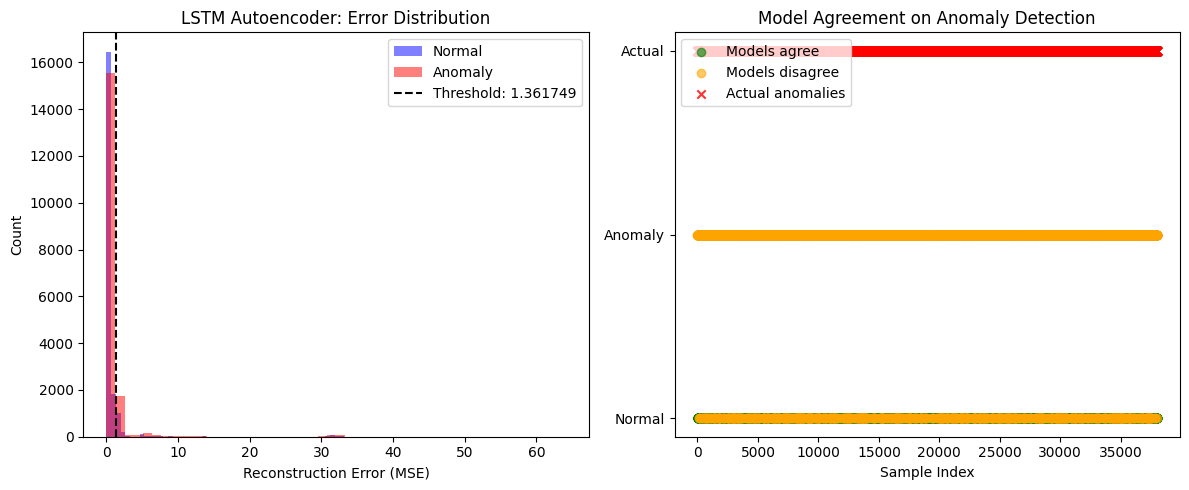

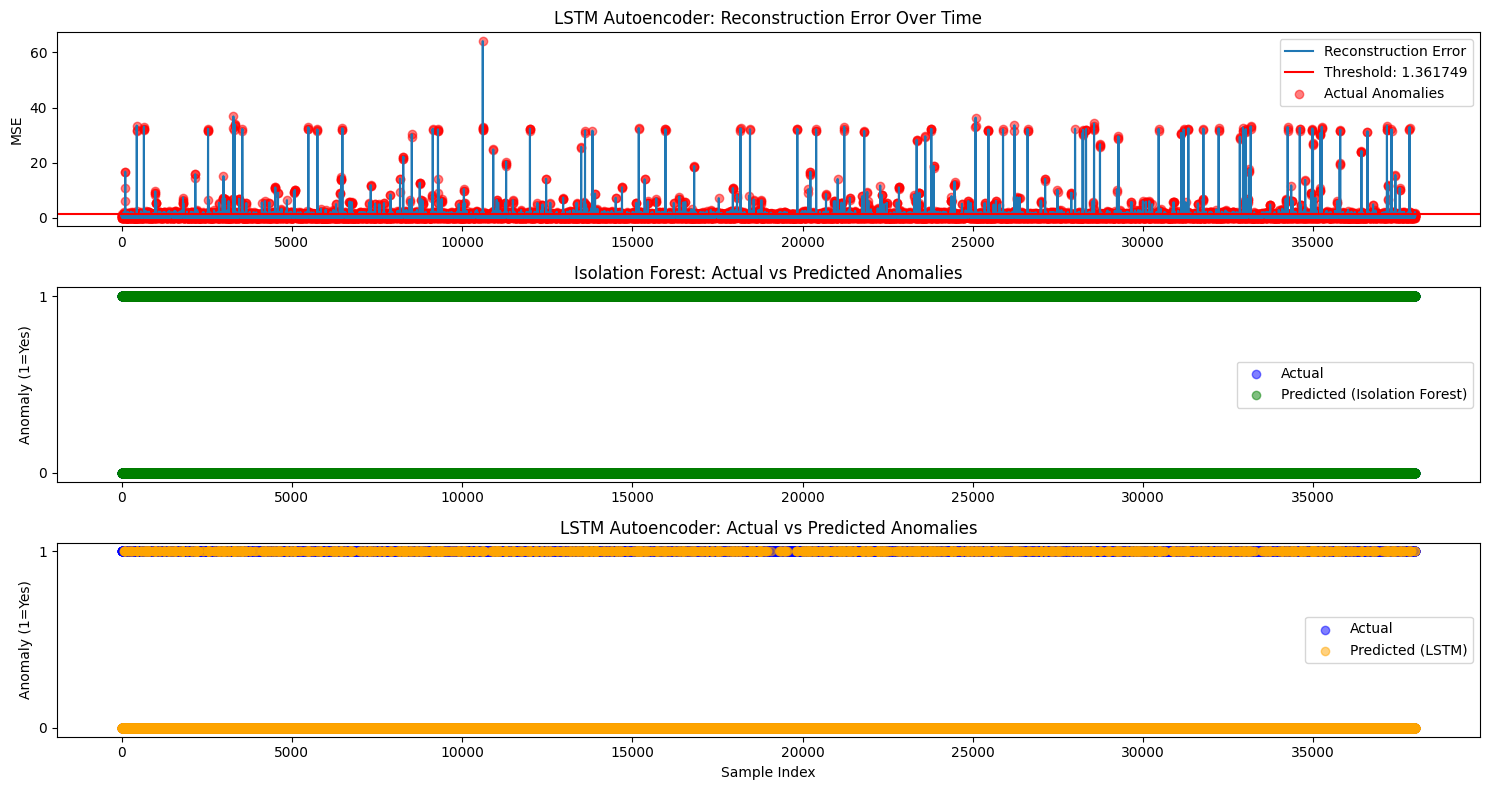


----- MODEL AGREEMENT -----
Models agree on 20984 out of 37998 samples (55.22%)
When models agree, accuracy: 0.9133
Ensemble (OR) F1 Score: 0.8792

Evaluation completed


In [17]:
def evaluate_models(y_true, y_pred_iso, y_pred_lstm, threshold_iso, threshold_lstm):

    models = {
        'Isolation Forest': y_pred_iso,
        'LSTM Autoencoder': y_pred_lstm
    }
    thresholds = {
        'Isolation Forest': threshold_iso,
        'LSTM Autoencoder': threshold_lstm
    }

    # Table header
    print("\n{:<20} {:<10} {:<10} {:<10} {:<10}".format(
        "Model", "Accuracy", "Precision", "Recall", "F1 Score"))
    print("-" * 65)

    results = {}

    # Calculate metrics for each model
    for model_name, y_pred in models.items():
        # Calculate metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        # Store results
        results[model_name] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'predictions': y_pred
        }

        # Print results row
        print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
            model_name, acc, prec, rec, f1))

    # Print confusion matrices
    print("\n----- CONFUSION MATRICES -----")
    for model_name, result in results.items():
        cm = confusion_matrix(y_true, result['predictions'])
        tn, fp, fn, tp = cm.ravel()

        print(f"\n{model_name}:")
        print(f"Threshold: {thresholds[model_name]:.6f}")
        print("          Predicted")
        print("          Normal   Anomaly")
        print(f"Actual    Normal   {tn:<8} {fp:<8}")
        print(f"          Anomaly  {fn:<8} {tp:<8}")

        print(f"\nTrue Negatives: {tn} (correctly identified normal)")
        print(f"False Positives: {fp} (normal incorrectly flagged as anomaly)")
        print(f"False Negatives: {fn} (missed anomalies)")
        print(f"True Positives: {tp} (correctly identified anomalies)")

        # Calculate additional metrics
        print(f"\nSensitivity (TPR): {tp/(tp+fn):.4f} if applicable")
        print(f"Specificity (TNR): {tn/(tn+fp):.4f} if applicable")
        print(f"False Alarm Rate: {fp/(fp+tn):.4f}")
        print(f"Miss Rate: {fn/(fn+tp):.4f}")

    # Determine best model
    best_model = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
    print(f"\n----- BEST MODEL -----")
    print(f"Based on F1 Score: {best_model}")

    return results

print("\nRunning model evaluation...")

# Get common indices for fair comparison
common_indices = np.arange(len(y_test_seq))

# Extract predictions for common indices
y_true_common = y_test_seq
y_pred_iso_common = y_pred_iso[seq_length-1:seq_length-1+len(X_test_seq)]  # Align with y_test_seq
y_pred_lstm_common = y_pred  # Already aligned with y_test_seq

# Run evaluation on common subset
results = evaluate_models(
    y_true_common,
    y_pred_iso_common,
    y_pred_lstm_common,
    threshold_iso=contamination,
    threshold_lstm=threshold
)


plt.figure(figsize=(12, 5))

# Plot Reconstruction Error Distribution for LSTM
plt.subplot(1, 2, 1)
plt.hist(mse[y_test_seq == 0], bins=50, alpha=0.5, label='Normal', color='blue')
plt.hist(mse[y_test_seq == 1], bins=50, alpha=0.5, label='Anomaly', color='red')
plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.title('LSTM Autoencoder: Error Distribution')
plt.tight_layout()

# Plot anomaly scores comparison
plt.subplot(1, 2, 2)
agreement = (y_pred_iso_common == y_pred_lstm_common)
plt.scatter(common_indices[agreement], y_pred_iso_common[agreement],
           alpha=0.6, c='green', label='Models agree')
plt.scatter(common_indices[~agreement], y_pred_iso_common[~agreement],
           alpha=0.6, c='orange', label='Models disagree')
plt.scatter(common_indices[y_true_common == 1], np.ones(np.sum(y_true_common == 1)) * 2,
           alpha=0.8, c='red', marker='x', label='Actual anomalies')
plt.yticks([0, 1, 2], ['Normal', 'Anomaly', 'Actual'])
plt.xlabel('Sample Index')
plt.title('Model Agreement on Anomaly Detection')
plt.legend()
plt.tight_layout()

plt.savefig('model_comparison.png')
plt.show()

# Visualization of anomaly detection performance over time
plt.figure(figsize=(15, 8))

# Plot the reconstruction error from LSTM
plt.subplot(3, 1, 1)
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold: {threshold:.6f}')
anomaly_indices = np.where(y_true_common == 1)[0]
plt.scatter(anomaly_indices, mse[anomaly_indices], color='red', label='Actual Anomalies', alpha=0.5)
plt.title('LSTM Autoencoder: Reconstruction Error Over Time')
plt.ylabel('MSE')
plt.legend()

# Plot the actual vs predicted anomalies for Isolation Forest
plt.subplot(3, 1, 2)
plt.scatter(range(len(y_true_common)), y_true_common, alpha=0.5, label='Actual', color='blue')
plt.scatter(range(len(y_pred_iso_common)), y_pred_iso_common, alpha=0.5, label='Predicted (Isolation Forest)', color='green')
plt.title('Isolation Forest: Actual vs Predicted Anomalies')
plt.ylabel('Anomaly (1=Yes)')
plt.yticks([0, 1])
plt.legend()

# Plot the actual vs predicted anomalies for LSTM
plt.subplot(3, 1, 3)
plt.scatter(range(len(y_true_common)), y_true_common, alpha=0.5, label='Actual', color='blue')
plt.scatter(range(len(y_pred_lstm_common)), y_pred_lstm_common, alpha=0.5, label='Predicted (LSTM)', color='orange')
plt.title('LSTM Autoencoder: Actual vs Predicted Anomalies')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly (1=Yes)')
plt.yticks([0, 1])
plt.legend()

plt.tight_layout()
plt.savefig('anomaly_detection_over_time.png')
plt.show()

# Calculate and display model agreement statistics
agreement_count = np.sum(y_pred_iso_common == y_pred_lstm_common)
agreement_percentage = agreement_count / len(y_pred_iso_common) * 100

print(f"\n----- MODEL AGREEMENT -----")
print(f"Models agree on {agreement_count} out of {len(y_pred_iso_common)} samples ({agreement_percentage:.2f}%)")

# When both models agree, how accurate are they?
both_agree_indices = (y_pred_iso_common == y_pred_lstm_common)
if np.any(both_agree_indices):
    both_agree_acc = accuracy_score(y_true_common[both_agree_indices], y_pred_iso_common[both_agree_indices])
    print(f"When models agree, accuracy: {both_agree_acc:.4f}")

# Calculate F1 score for ensemble (majority voting)
ensemble_pred = ((y_pred_iso_common + y_pred_lstm_common) >= 1).astype(int)
ensemble_f1 = f1_score(y_true_common, ensemble_pred, zero_division=0)
print(f"Ensemble (OR) F1 Score: {ensemble_f1:.4f}")

print("\nEvaluation completed")